In [42]:
%matplotlib inline

## Software Comparison Project with NIDM-Results

This notebook demonstates how to reproduce the results presented in the Software Comparison Project publication using NIDM-Results packs available at [NeuroVault (2071)](http://neurovault.org/collections/2071/). We give visual comparisons between axial slices of the excursion set images and T-statistics for each software packages, as well as quantitative comparisons with Euler Characteristics, Bland-Altman plots and Sørensen–Dice coefficients.


In [43]:
import os
from subprocess import check_call
import zipfile
import json
from urllib2 import urlopen, URLError, HTTPError
from urllib2 import Request
from nilearn import plotting
import nipype

### Download the NIDM-Results packs from NeuroVault

 - Query NeuroVault's API to retreive all NIDM packs in collection 2071
 - Download and save the packs in sub-folder `input/ds001` 

In [44]:
nv_collection ='2209'
study ='ds001'


request = Request('http://neurovault.org/api/collections/' + nv_collection + '/nidm_results/?limit=184&format=json')
response = urlopen(request)
elevations = response.read()
data = json.loads(elevations)

pwd = os.path.dirname(os.path.realpath('__file__'))
input_dir = os.path.join(pwd, "input")
data_dir = os.path.join(input_dir, study)

if not os.path.isdir(data_dir):
    if not os.path.isdir(input_dir):
        os.makedirs(input_dir)
    os.makedirs(data_dir)

for nidm_result in data["results"]:
    url = nidm_result["zip_file"]
    study_name = nidm_result["name"]

    localzip = os.path.join(data_dir, study_name + ".zip")
    localzip_rel = localzip.replace(pwd, '.')
    if not os.path.isfile(localzip):
        # Copy .nidm.zip export locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + localzip_rel)
            with open(localzip, "wb") as local_file:
                local_file.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + e.code + url])
        except URLError, e:
            raise Exception(["URL Error:" + e.reason + url])
    else:
        print(url + " already downloaded at " + localzip_rel)

for afni_image, local_name in (
        ('Negative_clustered_t_stat.nii.gz', 'afni_exc_set_neg.nii.gz'), 
        ('Positive_clustered_t_stat.nii.gz', 'afni_exc_set_pos.nii.gz'),
        ('3dMEMA_result_t_stat_masked.nii.gz', 'afni_stat.nii.gz'),
        ('mask.nii.gz', 'afni_mask.nii.gz')):

    url = "http://neurovault.org/media/images/" + nv_collection + '/' + afni_image
    local_file = os.path.join(data_dir, local_name)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + e.reason + url])
    else:
        print(url + " already downloaded at " + local_file)

for euler_char_file, local_name in (
        ('AFNI/LEVEL2/euler_chars.csv', 'afni_euler_chars.csv'),
        ('FSL/LEVEL2/group.gfeat/cope1.feat/stats/euler_chars.csv', 'fsl_euler_chars.csv'),
        ('SPM/LEVEL2/euler_chars.csv', 'spm_euler_chars.csv')):

    url = "https://raw.githubusercontent.com/AlexBowring/Software_Comparison/master/" + study + "/" + euler_char_file
    local_file = os.path.join(data_dir, local_name)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + e.reason + url])
    else:
        print(url + " already downloaded at " + local_file)

for resliced_image in (('afni_fsl_reslice.nii.gz', 'afni_fsl_reslice_pos_exc.nii.gz','afni_fsl_reslice_neg_exc.nii.gz',
                        'afni_reslice_fsl.nii.gz', 'afni_reslice_fsl_pos_exc.nii.gz','afni_reslice_fsl_neg_exc.nii.gz',
                        'afni_spm_reslice.nii.gz', 'afni_spm_reslice_pos_exc.nii.gz','afni_spm_reslice_neg_exc.nii.gz',
                        'afni_reslice_spm.nii.gz', 'afni_reslice_spm_pos_exc.nii.gz','afni_reslice_spm_neg_exc.nii.gz',
                        'fsl_spm_reslice.nii.gz', 'fsl_spm_reslice_pos_exc.nii.gz','fsl_spm_reslice_neg_exc.nii.gz',
                        'fsl_reslice_spm.nii.gz', 'fsl_reslice_spm_pos_exc.nii.gz','fsl_reslice_spm_neg_exc.nii.gz',)):
    url = "http://neurovault.org/media/images/" + nv_collection + '/' + resliced_image
    local_file = os.path.join(data_dir, resliced_image)
    if not os.path.isfile(local_file):
        # Copy file locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + local_file)
            with open(local_file, "wb") as local_fid:
                local_fid.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + str(e.code) + url])
        except URLError, e:
            raise Exception(["URL Error:" + e.reason + url])
    else:
        print(url + " already downloaded at " + local_file)

http://neurovault.org/collections/2209/group.gfeat.nidm.zip already downloaded at ./input/ds001/group.gfeat.nidm.zip
http://neurovault.org/collections/2209/spm_0001.nidm.zip already downloaded at ./input/ds001/spm_0001.nidm.zip
http://neurovault.org/collections/2209/spm_0002.nidm.zip already downloaded at ./input/ds001/spm_0002.nidm.zip
http://neurovault.org/media/images/2209/Negative_clustered_t_stat.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds001/afni_exc_set_neg.nii.gz
http://neurovault.org/media/images/2209/Positive_clustered_t_stat.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds001/afni_exc_set_pos.nii.gz
http://neurovault.org/media/images/2209/3dMEMA_result_t_stat_masked.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds001/afni_stat.nii.gz
http://neurovault.org/media/images/2209/mask.nii.gz already downloaded at /Users/maullz/Desktop/Software_Comparison/input/ds001/afni_mask.nii.gz
ht

In [45]:
import zipfile
import shutil

# *** SPM group activations
spm_pack = open('./input/' + study + '/spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file = './input/' + study + '/spm_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file)

# Unthresholded statistics
spm_stat_file = './input/' + study + '/spm_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic.nii.gz', spm_stat_file)

# Analysis mask
spm_mask_file = './input/' + study + '/spm_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', spm_mask_file)

# *** SPM group deactivations
spm_deact_pack = open('./input/' + study + '/spm_0002.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_deact_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file_neg = './input/' + study + '/spm_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file_neg)

# *** FSL group activations and deactivations
fsl_pack = open('./input/' + study + '/group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
fsl_exc_set_file = './input/' + study + '/fsl_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', fsl_exc_set_file)
fsl_exc_set_file_neg = './input/' + study + '/fsl_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', fsl_exc_set_file_neg)

# Unthresholded statistics
fsl_stat_file = './input/' + study + '/fsl_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', fsl_stat_file)

# Analysis mask
fsl_mask_file = './input/' + study + '/fsl_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', fsl_mask_file)

# *** AFNI group activations and deactivations
afni_mask_file = './input/' + study + '/afni_mask.nii.gz'
afni_exc_set_file = './input/' + study + '/afni_exc_set_pos.nii.gz'
afni_exc_set_file_neg = './input/' + study + '/afni_exc_set_neg.nii.gz'
afni_stat_file = './input/' + study + '/afni_stat.nii.gz'

exc_sets = dict()
exc_sets["afni"] = (afni_mask_file, (afni_exc_set_file, afni_exc_set_file_neg), afni_stat_file)
exc_sets["fsl"] = (fsl_mask_file, (fsl_exc_set_file, fsl_exc_set_file_neg), fsl_stat_file)
exc_sets["spm"] = (spm_mask_file, (spm_exc_set_file, spm_exc_set_file_neg), spm_stat_file)

# *** Resliced images
# FSL resliced onto AFNI
afni_fsl_reslice = './input/' + study + '/afni_fsl_reslice.nii.gz'
afni_fsl_reslice_pos_exc = './input/' + study + '/afni_fsl_reslice_pos_exc.nii.gz'
afni_fsl_reslice_neg_exc = './input/' + study + '/afni_fsl_reslice_neg_exc.nii.gz'
# AFNI resliced onto FSL
afni_reslice_fsl = './input/' + study + '/afni_reslice_fsl.nii.gz'
afni_reslice_fsl_pos_exc = './input/' + study + '/afni_reslice_fsl_pos_exc.nii.gz'
afni_reslice_fsl_neg_exc = './input/' + study + '/afni_reslice_fsl_neg_exc.nii.gz'

# SPM resliced onto AFNI
afni_spm_reslice = './input/' + study + '/afni_spm_reslice.nii.gz'
afni_spm_reslice_pos_exc = './input/' + study + '/afni_spm_reslice_pos_exc.nii.gz'
afni_spm_reslice_neg_exc = './input/' + study + '/afni_spm_reslice_neg_exc.nii.gz'
# AFNI resliced onto SPM
afni_reslice_spm = './input/' + study + '/afni_reslice_spm.nii.gz'
afni_reslice_spm_pos_exc = './input/' + study + '/afni_reslice_spm_pos_exc.nii.gz'
afni_reslice_spm_neg_exc = './input/' + study + '/afni_reslice_spm_neg_exc.nii.gz'

# SPM resliced onto FSL
fsl_spm_reslice  = './input/' + study + '/fsl_spm_reslice.nii.gz'
fsl_spm_reslice_pos_exc = './input/' + study + '/fsl_spm_reslice_pos_exc.nii.gz'
fsl_spm_reslice_neg_exc = './input/' + study + '/fsl_spm_reslice_neg_exc.nii.gz'
# FSL resliced onto SPM
fsl_reslice_spm = './input/' + study + '/fsl_reslice_spm.nii.gz'
fsl_reslice_spm_pos_exc = './input/' + study + '/fsl_reslice_spm_pos_exc.nii.gz'
fsl_reslice_spm_neg_exc = './input/' + study + '/fsl_reslice_spm_neg_exc.nii.gz'

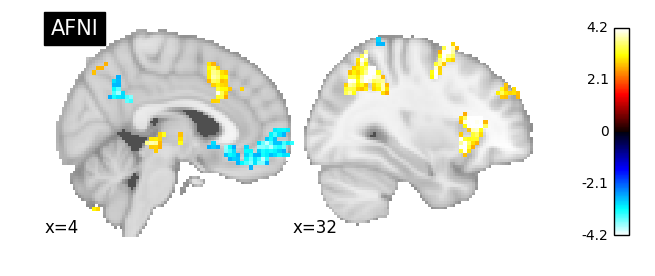

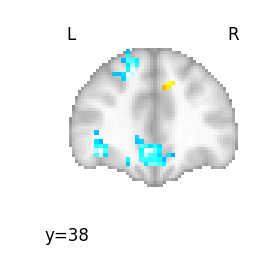

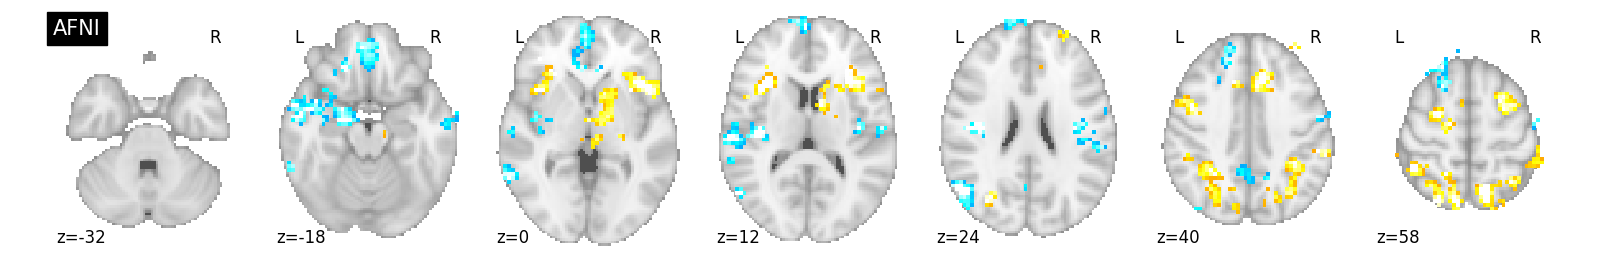

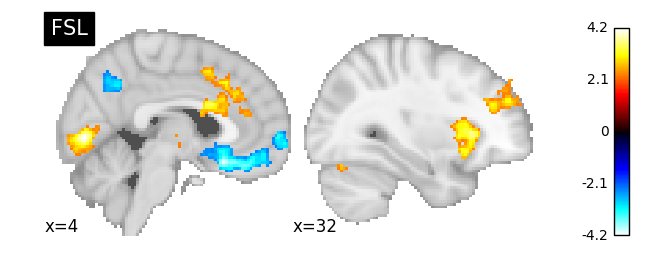

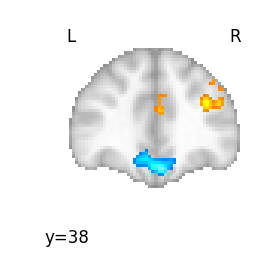

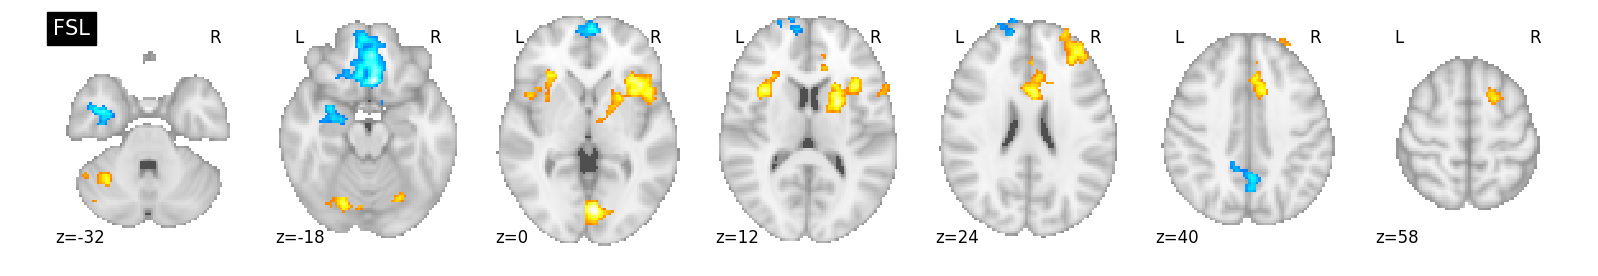

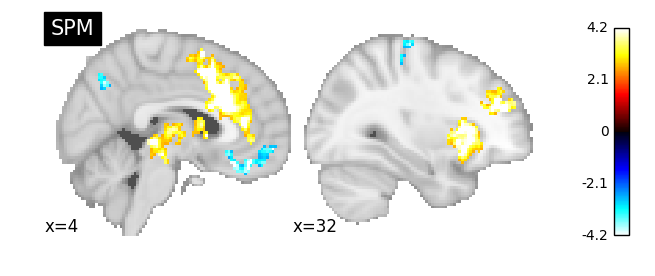

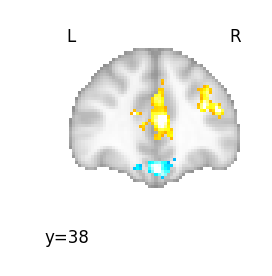

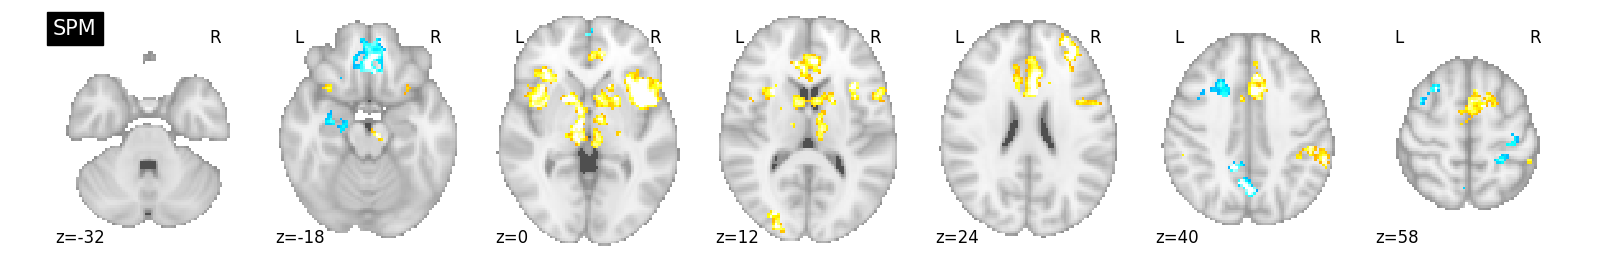

In [46]:
from nilearn import plotting
from nilearn.image import math_img
import numpy as np
from nilearn.masking import apply_mask
from nilearn.image import load_img, new_img_like
from nilearn._utils.niimg_conversions import _safe_get_data
import nibabel as nib

for soft, (mask_file, (exc_set_file, exc_set_file_neg), stat_file) in sorted(exc_sets.items()):
    # Remove NaNs
    n = nib.load(exc_set_file)
    d = n.get_data()
    exc_set_nonan = nib.Nifti1Image(np.nan_to_num(d), n.affine, header=n.header)
    
    n = nib.load(exc_set_file_neg)
    d = n.get_data()
    exc_set_neg_nonan = nib.Nifti1Image(np.nan_to_num(d), n.affine, header=n.header)
    
    # Combine activations and deactivations in a single image 
    to_display = math_img("img1-img2", img1=exc_set_nonan, img2=exc_set_neg_nonan)

    # Display x=4, y=32 and y=38 as in the manuscript
    display = plotting.plot_stat_map(to_display, display_mode='x', cut_coords=[4, 32], draw_cross=False, colorbar=True, 
                           title=soft.upper(), threshold=0.000001, vmax=4.2)
    display = plotting.plot_stat_map(to_display, cut_coords=[38], draw_cross=False, display_mode='y', 
                           threshold=0.000001, colorbar=False, vmax=4.2)
    # Additional plot: slices along z
    display = plotting.plot_stat_map(to_display, cut_coords=[-32, -18, 0, 12, 24, 40, 58], draw_cross=False, display_mode='z', 
                           threshold=0.000001, colorbar=False, vmax=4.2, title=soft.upper())
#     # Analysis mask
#     display = plotting.plot_roi(mask_file, title=soft.upper()+': Analysis mask')

#     # Analysis mask
#     display = plotting.plot_roi(mask_file, title=soft.upper()+': Analysis mask', 
#                                 cut_coords=7, draw_cross=False, display_mode='z')


plotting.show()

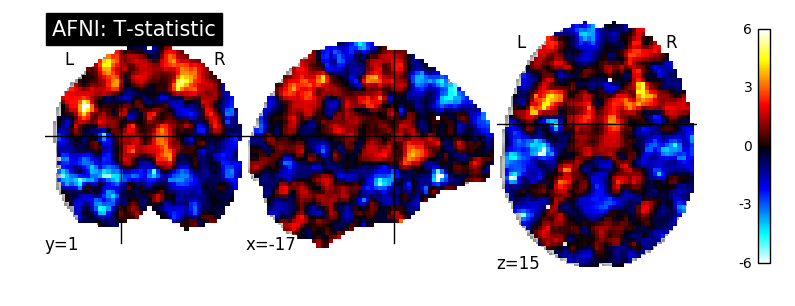

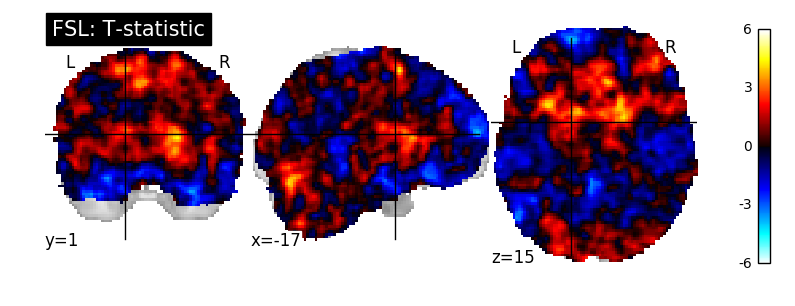

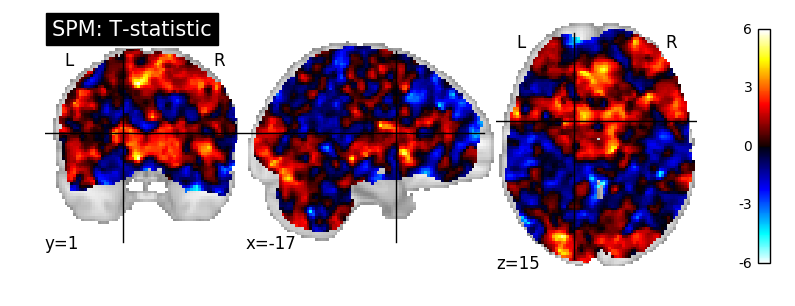

In [47]:
from nilearn import plotting
plotting.plot_stat_map(afni_stat_file, vmax=6, title="AFNI: T-statistic", display_mode='ortho', cut_coords=[-17, 1, 15])
plotting.plot_stat_map(fsl_stat_file, vmax=6, title="FSL: T-statistic", display_mode='ortho', cut_coords=[-17, 1, 15])
plotting.plot_stat_map(spm_stat_file, vmax=6, title="SPM: T-statistic", display_mode='ortho', cut_coords=[-17, 1, 15])

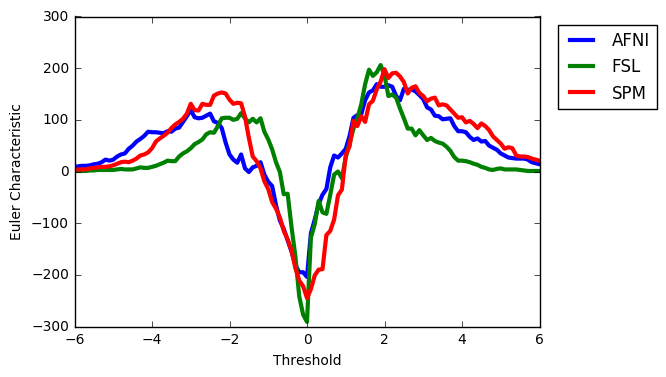

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

afni_euler_chars = pd.read_csv('./input/' + study + '/afni_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_euler_chars = pd.read_csv('./input/' + study + '/fsl_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_euler_chars = pd.read_csv('./input/' + study + '/spm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
euler_chars = pd.concat([afni_euler_chars, fsl_euler_chars, spm_euler_chars], axis=1)

clm_list = []
for column in euler_chars.columns:
    clm_list.append(column)

thresholds = euler_chars[clm_list[0]].values
afni_ecs = euler_chars[clm_list[1]].values
fsl_ecs = euler_chars[clm_list[2]].values
spm_ecs = euler_chars[clm_list[3]].values

plt.plot(thresholds, afni_ecs, lw = '3')
plt.plot(thresholds, fsl_ecs, lw = '3')
plt.plot(thresholds, spm_ecs, lw = '3')

plt.xlabel('Threshold')
plt.ylabel('Euler Characteristic')

plt.legend(['AFNI', 'FSL', 'SPM'], bbox_to_anchor=(1.27, 1))

plt.show()

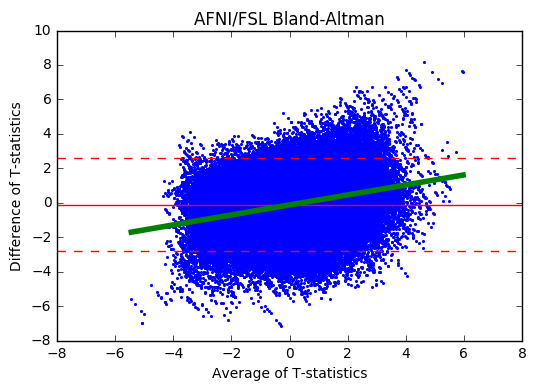

Mean = -0.105367
SD = 1.37893


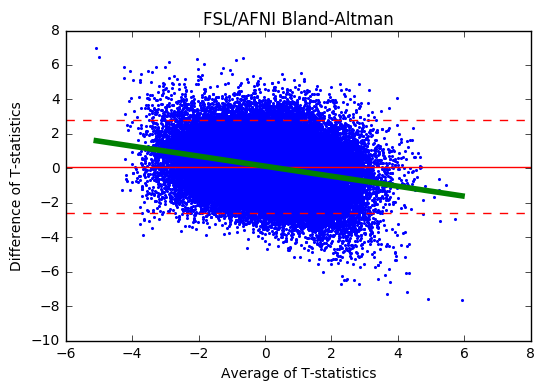

Mean = 0.100567
SD = 1.38303


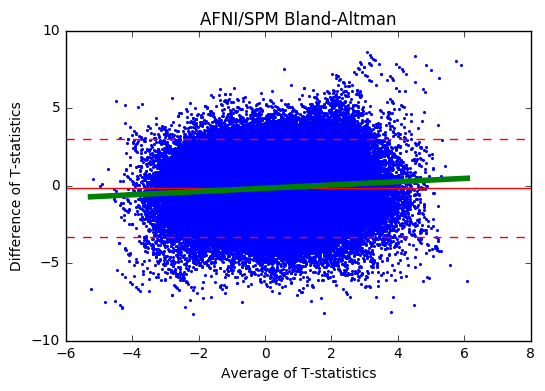

Mean = -0.157098
SD = 1.62073


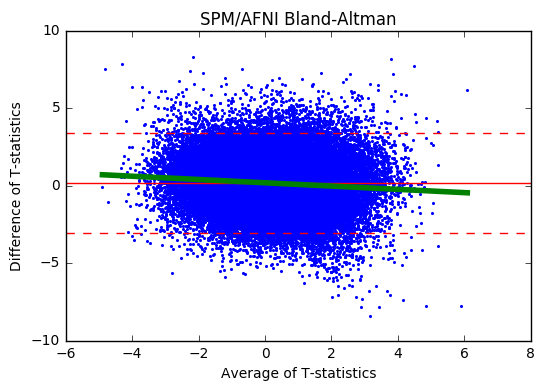

Mean = 0.157681
SD = 1.63361


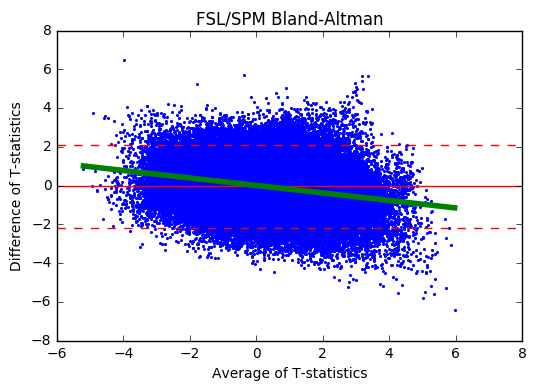

Mean = -0.0410214
SD = 1.0996


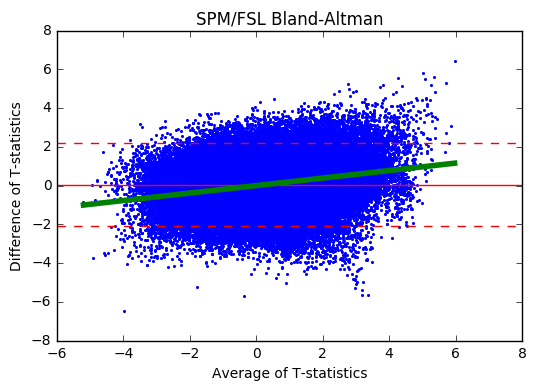

Mean = 0.0410214
SD = 1.0996


In [49]:
# Get data from stat images
afni_dat = nib.load(afni_stat_file).get_data()
fsl_dat = nib.load(fsl_stat_file).get_data()
spm_dat = nib.load(spm_stat_file).get_data()

# Get data from resliced images
afni_res_fsl_dat = nib.load(afni_reslice_fsl).get_data()
afni_res_spm_dat = nib.load(afni_reslice_spm).get_data()
fsl_res_spm_dat = nib.load(fsl_reslice_spm).get_data()
afni_fsl_res_dat = nib.load(afni_fsl_reslice).get_data()
afni_spm_res_dat = nib.load(afni_spm_reslice).get_data()
fsl_spm_res_dat = nib.load(fsl_spm_reslice).get_data()

afni_1d = np.reshape(afni_dat, -1)
fsl_1d = np.reshape(fsl_dat, -1)
spm_1d = np.reshape(spm_dat, -1)
afni_res_fsl_1d = np.reshape(afni_res_fsl_dat, -1)
afni_fsl_res_1d = np.reshape(afni_fsl_res_dat, -1)
afni_res_spm_1d = np.reshape(afni_res_spm_dat, -1)
afni_spm_res_1d = np.reshape(afni_spm_res_dat, -1)
fsl_res_spm_1d = np.reshape(fsl_res_spm_dat, -1)
fsl_spm_res_1d = np.reshape(fsl_spm_res_dat, -1)


def bland_altman_plot(data1, data2, *args, **kwargs):
    in_mask_indices = np.logical_not(np.logical_or(
    np.logical_or(np.isnan(data1), np.absolute(data1) == 0),
    np.logical_or(np.isnan(data2), np.absolute(data2) == 0)))

    data1 = data1[in_mask_indices]
    data2 = data2[in_mask_indices]

    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    
    plt.scatter(mean, diff, marker = '.', linewidth = '0', *args, **kwargs)
    mean_line = plt.axhline(md,           color='red', linestyle='-')
    pos_95_prct = plt.axhline(md + 1.96*sd, color='red', linestyle='--')
    neg_95_prct = plt.axhline(md - 1.96*sd, color='red', linestyle='--')
    plt.plot(np.unique(mean), np.poly1d(np.polyfit(mean, diff, 1))(np.unique(mean)), color = 'green', lw = 4)
    plt.xlabel('Average of T-statistics')
    plt.ylabel('Difference of T-statistics')
    return md, sd

bland = bland_altman_plot(afni_res_fsl_1d, fsl_1d)
plt.title('AFNI/FSL Bland-Altman')
plt.show()
mean, sd = bland
print "Mean = %s" % mean
print "SD = %s" % sd

bland = bland_altman_plot(afni_fsl_res_1d, afni_1d)
plt.title('FSL/AFNI Bland-Altman')
plt.show()
mean, sd = bland
print "Mean = %s" % mean
print "SD = %s" % sd

bland = bland_altman_plot(afni_res_spm_1d, spm_1d)
plt.title('AFNI/SPM Bland-Altman')
plt.show()
mean, sd = bland
print "Mean = %s" % mean
print "SD = %s" % sd

bland = bland_altman_plot(afni_spm_res_1d, afni_1d)
plt.title('SPM/AFNI Bland-Altman')
plt.show()
mean, sd = bland
print "Mean = %s" % mean
print "SD = %s" % sd

bland = bland_altman_plot(fsl_res_spm_1d, spm_1d)
plt.title('FSL/SPM Bland-Altman')
plt.show()
mean, sd = bland
print "Mean = %s" % mean
print "SD = %s" % sd

bland = bland_altman_plot(fsl_spm_res_1d, fsl_1d)
plt.title('SPM/FSL Bland-Altman')
plt.show()
mean, sd = bland
print "Mean = %s" % mean
print "SD = %s" % sd

In [50]:
# Get data from excursion set images
afni_pos_dat = nib.load(afni_exc_set_file).get_data()
afni_neg_dat = nib.load(afni_exc_set_file_neg).get_data()
fsl_pos_dat = nib.load(fsl_exc_set_file).get_data()
fsl_neg_dat = nib.load(fsl_exc_set_file_neg).get_data()
spm_pos_dat = nib.load(spm_exc_set_file).get_data()
spm_neg_dat = nib.load(spm_exc_set_file_neg).get_data()

# Get data from resliced images
afni_res_fsl_pos_dat = nib.load(afni_reslice_fsl_pos_exc).get_data()
afni_res_fsl_neg_dat = nib.load(afni_reslice_fsl_neg_exc).get_data()
afni_fsl_res_pos_dat = nib.load(afni_fsl_reslice_pos_exc).get_data()
afni_fsl_res_neg_dat = nib.load(afni_fsl_reslice_neg_exc).get_data()

afni_res_spm_pos_dat = nib.load(afni_reslice_spm_pos_exc).get_data()
afni_res_spm_neg_dat = nib.load(afni_reslice_spm_neg_exc).get_data()
afni_spm_res_pos_dat = nib.load(afni_spm_reslice_pos_exc).get_data()
afni_spm_res_neg_dat = nib.load(afni_spm_reslice_neg_exc).get_data()

fsl_res_spm_pos_dat = nib.load(fsl_reslice_spm_pos_exc).get_data()
fsl_res_spm_neg_dat = nib.load(fsl_reslice_spm_neg_exc).get_data()
fsl_spm_res_pos_dat = nib.load(fsl_spm_reslice_pos_exc).get_data()
fsl_spm_res_neg_dat = nib.load(fsl_spm_reslice_neg_exc).get_data()

def sorrenson_dice(data1, data2):
    data1 = np.nan_to_num(data1)
    data2 = np.nan_to_num(data2)
    
    zero_indices_data1 = data1 == 0
    non_zero_indices_data1 = data1 != 0
    zero_indices_data2 = data2 == 0
    non_zero_indices_data2 = data2 != 0
    
    intersection_data = data1 
    intersection_data[zero_indices_data2] = 0 # All values close to 0 in data1 or data2 are 0 in the intersection array
    intersection_indices = intersection_data != 0
    intersection_data[intersection_indices] = 1 # All values in the union of data1 and data2 are set to 1
    numerator = 2*np.sum(intersection_data)
    
    data1[non_zero_indices_data1] = 1
    data2[non_zero_indices_data2] = 1
    denominator = np.sum(data1) + np.sum(data2)
    
    dice_coefficient = numerator/denominator
    return dice_coefficient

afni_res_fsl_pos_dice = sorrenson_dice(afni_res_fsl_pos_dat, fsl_pos_dat)
afni_fsl_res_pos_dice = sorrenson_dice(afni_fsl_res_pos_dat, afni_pos_dat)
afni_res_fsl_neg_dice = sorrenson_dice(afni_res_fsl_neg_dat, fsl_neg_dat)
afni_fsl_res_neg_dice = sorrenson_dice(afni_fsl_res_neg_dat, afni_neg_dat)

afni_res_spm_pos_dice = sorrenson_dice(afni_res_spm_pos_dat, spm_pos_dat)
afni_spm_res_pos_dice = sorrenson_dice(afni_spm_res_pos_dat, afni_pos_dat)
afni_res_spm_neg_dice = sorrenson_dice(afni_res_spm_neg_dat, spm_neg_dat)
afni_spm_res_neg_dice = sorrenson_dice(afni_spm_res_neg_dat, afni_neg_dat)

fsl_res_spm_pos_dice = sorrenson_dice(fsl_res_spm_pos_dat, spm_pos_dat)
fsl_spm_res_pos_dice = sorrenson_dice(fsl_spm_res_pos_dat, fsl_pos_dat)
fsl_res_spm_neg_dice = sorrenson_dice(fsl_res_spm_neg_dat, spm_neg_dat)
fsl_spm_res_neg_dice = sorrenson_dice(fsl_spm_res_neg_dat, fsl_neg_dat)

print "AFNI/FSL positive activation dice coefficient = %s" % afni_res_fsl_pos_dice
print "FSL/AFNI positive activation dice coefficient = %s\n" % afni_fsl_res_pos_dice

print "AFNI/FSL negative activation dice coefficient = %s" % afni_res_fsl_neg_dice
print "FSL/AFNI negative activation dice coefficient = %s\n" % afni_fsl_res_neg_dice

print "AFNI/SPM positive activation dice coefficient = %s" % afni_res_spm_pos_dice
print "SPM/AFNI positive activation dice coefficient = %s\n" % afni_spm_res_pos_dice

print "AFNI/SPM negative activation dice coefficient = %s" % afni_res_spm_neg_dice
print "SPM/AFNI negative activation dice coefficient = %s\n" % afni_spm_res_neg_dice

print "FSL/SPM positive activation dice coefficient = %s" % fsl_res_spm_pos_dice
print "SPM/FSL positive activation dice coefficient = %s\n" % fsl_spm_res_pos_dice

print "FSL/SPM negative activation dice coefficient = %s" % fsl_res_spm_neg_dice
print "SPM/FSL negative activation dice coefficient = %s\n" % fsl_spm_res_neg_dice

AFNI/FSL positive activation dice coefficient = 0.195961995249
FSL/AFNI positive activation dice coefficient = 0.183079677708

AFNI/FSL negative activation dice coefficient = 0.198402613905
FSL/AFNI negative activation dice coefficient = 0.195269860522

AFNI/SPM positive activation dice coefficient = 0.226246834746
SPM/AFNI positive activation dice coefficient = 0.210545998504

AFNI/SPM negative activation dice coefficient = 0.129212401309
SPM/AFNI negative activation dice coefficient = 0.122829581994

FSL/SPM positive activation dice coefficient = 0.365175154548
SPM/FSL positive activation dice coefficient = 0.365175154548

FSL/SPM negative activation dice coefficient = 0.333732057416
SPM/FSL negative activation dice coefficient = 0.333732057416



In [51]:
AFNI/FSL positive activation dice coefficient = 0.218645418327
AFNI/FSL negative activation dice coefficient = 0.273926601103
AFNI/SPM positive activation dice coefficient = 0.237076866675
AFNI/SPM negative activation dice coefficient = 0.203885823939
FSL/SPM positive activation dice coefficient = 0.365175154548
FSL/SPM negative activation dice coefficient = 0.333732057416

SyntaxError: invalid syntax (<ipython-input-51-41456f701fda>, line 1)